# Leaf Morphology Analysis
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: August 31, 2021 </br>
**Description**: Leaf morphology traits can be quantified using the Aradeepopsis tool https://github.com/Gregor-Mendel-Institute/aradeepopsis to generate a csv file with different traits. This file can subsequently be analyzed using dimensionality reduction and clustering techniques with the following workflow.

In [1]:
#Load required dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
import math

In [2]:
# Set random seed for reproducibility
np.random.seed(31415)

In [3]:
#Set path to save plot
save_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021"

## Load and Clean Data

In [4]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021/Leaf Morphology Aradeepopsis Data"
filename = "aradeepopsis_traits.csv"
path_to_file = os.path.join(base_path, filename)
df = pd.read_csv(path_to_file)

#Metadata
base_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021"
filename = "Leaf_Morphology_metadata.csv"
path_to_file = os.path.join(base_path, filename)
metadata = pd.read_csv(path_to_file)

In [5]:
df.head()

,file,format,plant_region_red_channel,plant_region_green_channel,plant_region_blue_channel,plant_region_chroma_ratio,plant_region_chroma_difference,plant_region_chroma_base,plant_region_green_strength,plant_region_blue_green_ratio,...,class_norm_solidity,class_norm_aspect_ratio,class_norm_red_channel,class_norm_green_channel,class_norm_blue_channel,class_norm_chroma_ratio,class_norm_chroma_difference,class_norm_chroma_base,class_norm_green_strength,class_norm_blue_green_ratio
0,4-6 6,jpg,161.363813,200.241496,115.660310,1.445661,-61.729434,1.383450,0.419560,0.577604,...,0.711846,1.765397,161.363813,200.241496,115.660310,1.445661,-61.729434,1.383450,0.419560,0.577604
1,33-10 11,jpg,119.873371,149.874937,62.678575,1.641998,-58.598964,1.218029,0.450851,0.418206,...,0.571485,1.236062,119.873371,149.874937,62.678575,1.641998,-58.598964,1.218029,0.450851,0.418206
2,33-11 3,jpg,113.360347,142.714017,53.439070,1.711205,-59.314308,1.168767,0.461092,0.374449,...,0.531022,1.386523,113.360347,142.714017,53.439070,1.711205,-59.314308,1.168767,0.461092,0.374449
3,37-9 6,jpg,110.790618,143.237782,57.560419,1.701656,-59.062264,1.175326,0.459701,0.401852,...,0.658664,1.143779,110.790618,143.237782,57.560419,1.701656,-59.062264,1.175326,0.459701,0.401852
4,48-1 4,jpg,98.883642,127.723000,50.846455,1.706043,-52.857951,1.172303,0.460341,0.398099,...,0.578027,1.208959,98.883642,127.723000,50.846455,1.706043,-52.857951,1.172303,0.460341,0.398099


In [6]:
metadata.head()

,genotype,line
0,Col,Col
1,H4_septuple,H4
2,rH4-1,68-21C
3,rH4-2,68-18D
4,R3K-1,2-1


In [7]:
# Drop format column
df.drop(['format'],axis=1,inplace=True)

In [8]:
# Add metadata column with sample genotype to each sample row
df.insert(1, 'genotype', "NA")

In [9]:
for i in range(df.shape[0]):
    filename = df.iloc[i,0].split()[0]
    idx = metadata.index[metadata['line']==filename]
    genotype = metadata.iloc[idx,0].item()
    df.iloc[i, 1] = genotype

In [10]:
def rm_badreps(df, sample_name):
    idx = df.index[df['file']==sample_name]
    df.drop(idx,inplace=True)
    return df

In [11]:
# Remove samples that performed poorly with CNN
# 2-1 8, 7-2 1, 13-6 8
df = rm_badreps(df, '2-1 8')
df = rm_badreps(df, '7-2 1')
df = rm_badreps(df, '13-6 8')
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [12]:
df

,file,genotype,plant_region_red_channel,plant_region_green_channel,plant_region_blue_channel,plant_region_chroma_ratio,plant_region_chroma_difference,plant_region_chroma_base,plant_region_green_strength,plant_region_blue_green_ratio,...,class_norm_solidity,class_norm_aspect_ratio,class_norm_red_channel,class_norm_green_channel,class_norm_blue_channel,class_norm_chroma_ratio,class_norm_chroma_difference,class_norm_chroma_base,class_norm_green_strength,class_norm_blue_green_ratio
0,4-6 6,K5R-1,161.363813,200.241496,115.660310,1.445661,-61.729434,1.383450,0.419560,0.577604,...,0.711846,1.765397,161.363813,200.241496,115.660310,1.445661,-61.729434,1.383450,0.419560,0.577604
1,33-10 11,K44A-1,119.873371,149.874937,62.678575,1.641998,-58.598964,1.218029,0.450851,0.418206,...,0.571485,1.236062,119.873371,149.874937,62.678575,1.641998,-58.598964,1.218029,0.450851,0.418206
2,33-11 3,K44A-2,113.360347,142.714017,53.439070,1.711205,-59.314308,1.168767,0.461092,0.374449,...,0.531022,1.386523,113.360347,142.714017,53.439070,1.711205,-59.314308,1.168767,0.461092,0.374449
3,37-9 6,Y51F-2,110.790618,143.237782,57.560419,1.701656,-59.062264,1.175326,0.459701,0.401852,...,0.658664,1.143779,110.790618,143.237782,57.560419,1.701656,-59.062264,1.175326,0.459701,0.401852
4,48-1 4,R77K-1,98.883642,127.723000,50.846455,1.706043,-52.857951,1.172303,0.460341,0.398099,...,0.578027,1.208959,98.883642,127.723000,50.846455,1.706043,-52.857951,1.172303,0.460341,0.398099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,33-10 10,K44A-1,124.913597,157.250129,61.832143,1.684109,-63.877259,1.187571,0.457128,0.393209,...,0.501316,1.273056,124.913597,157.250129,61.832143,1.684109,-63.877259,1.187571,0.457128,0.393209
386,33-10 12,K44A-1,113.492033,144.712603,51.580651,1.753320,-62.176261,1.140693,0.467138,0.356435,...,0.575960,1.978335,113.492033,144.712603,51.580651,1.753320,-62.176261,1.140693,0.467138,0.356435
387,37-9 3,Y51F-2,128.251934,161.241807,75.186495,1.585166,-59.522593,1.261698,0.442146,0.466297,...,0.749647,1.415604,128.251934,161.241807,75.186495,1.585166,-59.522593,1.261698,0.442146,0.466297
388,48-1 1,R77K-1,115.387345,148.397814,62.042391,1.672750,-59.682946,1.195636,0.455449,0.418082,...,0.596638,1.245471,115.387345,148.397814,62.042391,1.672750,-59.682946,1.195636,0.455449,0.418082


## Individual plant data

### Perform PCA

In [13]:
#Make data frame
#Separate the features
x = df.iloc[:,2:].values
#Separate the labels
y = df.loc[:,['file']].values
y_cat = df.loc[:,['genotype']].values
# Standardize the features
x = StandardScaler().fit_transform(x)
n_features = x.shape[1]

In [14]:
# Run PCA to obtain all PCs
pca = PCA(n_components=n_features)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [15]:
# Run PCA to obtain all PCs
pca = PCA(n_components=n_features)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents[:,:3], columns=['PC1','PC2','PC3'])
finalDf = pd.concat([principalDf, df[['file']]], axis = 1)
finalDf = pd.concat([finalDf, df[['genotype']]], axis = 1)
finalDf.head()

,PC1,PC2,PC3,file,genotype
0,-0.539796,9.480925,-0.073873,4-6 6,K5R-1
1,4.526288,-3.924315,0.118979,33-10 11,K44A-1
2,-0.654300,-3.346329,2.247589,33-11 3,K44A-2
3,-0.301789,-3.670009,-2.013784,37-9 6,Y51F-2
4,0.312904,-5.406897,0.135349,48-1 4,R77K-1


In [16]:
# Print proportions of explained variance by each PC
ex_var = pca.explained_variance_ratio_

In [17]:
ex_var.cumsum().shape

(40,)

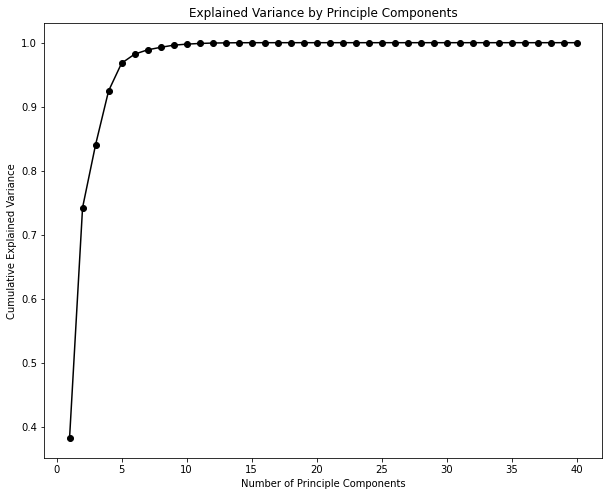

In [18]:
# Visualize scree plot
plt.figure(figsize=(10,8))
plt.plot(range(1,41),ex_var.cumsum(), marker='o', color='black')
plt.title('Explained Variance by Principle Components')
plt.xlabel("Number of Principle Components")
plt.ylabel('Cumulative Explained Variance')

plt.savefig(save_path+"/PCA/scree.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/scree.pdf", bbox_inches='tight')

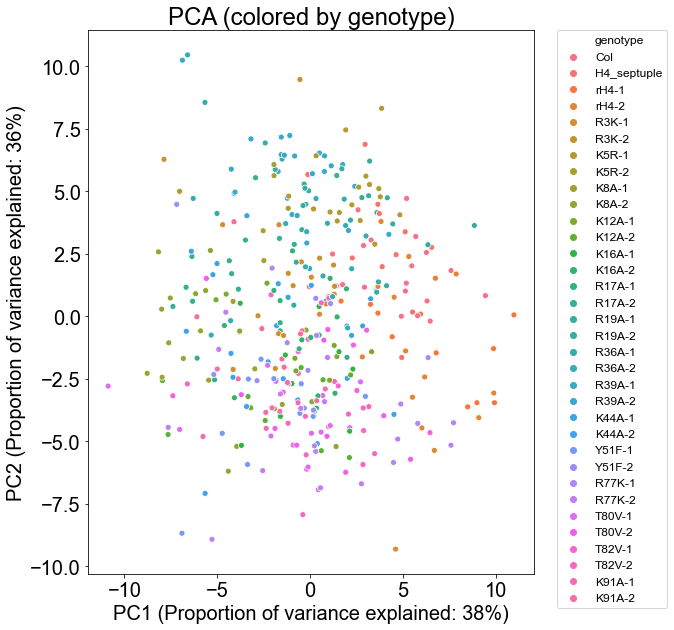

In [19]:
# Visualize 2D projection

# Set Plotting Parameters
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 2.5

# Color by genotype
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)')
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.savefig(save_path+"/PCA/genotypes.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypes.pdf", bbox_inches='tight')

## Perform k-means Clustering

In [20]:
# Run k-means
n_clusters=3
kmeans_labels = KMeans(n_clusters=n_clusters).fit_predict(x)

In [21]:
finalDf['cluster'] = kmeans_labels
finalDf.head()

,PC1,PC2,PC3,file,genotype,cluster
0,-0.539796,9.480925,-0.073873,4-6 6,K5R-1,0
1,4.526288,-3.924315,0.118979,33-10 11,K44A-1,2
2,-0.654300,-3.346329,2.247589,33-11 3,K44A-2,1
3,-0.301789,-3.670009,-2.013784,37-9 6,Y51F-2,1
4,0.312904,-5.406897,0.135349,48-1 4,R77K-1,1


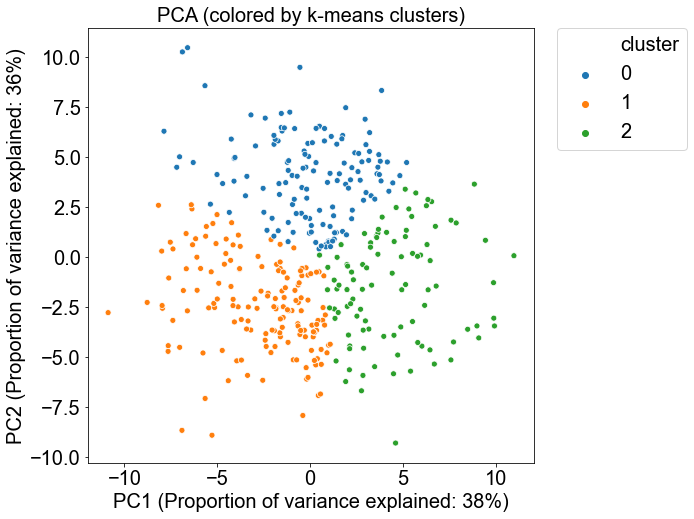

In [22]:
# Visualize 2D projection with k-means labels

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means clusters)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='cluster', palette=sns.color_palette("tab10",n_clusters))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(save_path+"/PCA/kmeans.png", bbox_inches='tight')

## Average data by genotype

In [23]:
# Average data by genotype
avg_finalDf = finalDf.groupby('genotype').mean()

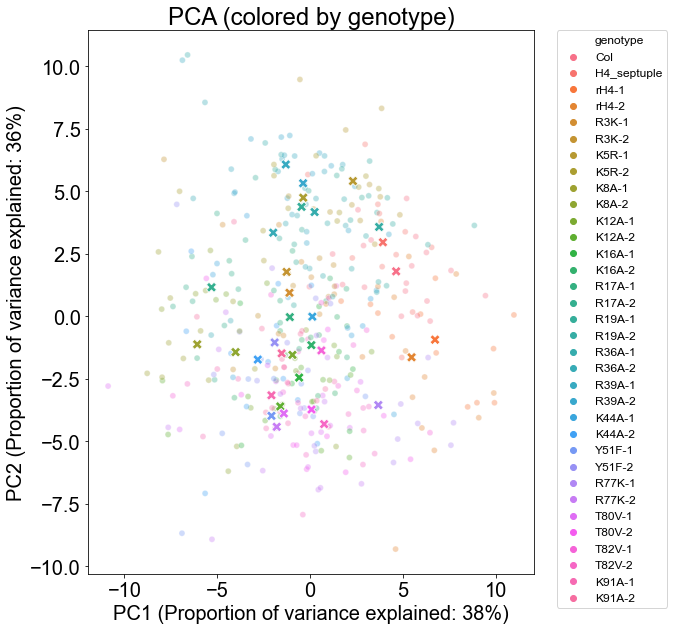

In [24]:
# Visualize averages on top of individual replicates
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)')
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue=avg_finalDf.index, hue_order=order, 
                palette=sns.color_palette("husl", 34), marker='X', s=100, legend=False)
ax.set(xlabel=xlab, ylabel = ylab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.savefig(save_path+"/PCA/genotypecols_genotypeavg.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypecols_genotypeavg.pdf", bbox_inches='tight')

## k-means Clustering

In [25]:
avg_finalDf['cluster'] = 'NA'

In [26]:
# assign genotypes to cluster by mode from biological replicates
for genotype in avg_finalDf.index:
    group = finalDf.loc[finalDf['genotype'] == genotype]
    cluster_num = group['cluster'].mode()
    final_cluster = cluster_num.iat[-1]
    avg_finalDf.at[genotype,"cluster"] = final_cluster

In [27]:
avg_finalDf.head()

,PC1,PC2,PC3,cluster
genotype,,,,
Col,4.642698,1.800958,-0.028996,2
H4_septuple,3.930387,2.965926,0.240602,2
K12A-1,-0.942506,-1.541807,-0.181562,1
K12A-2,-1.599407,-3.605304,0.872597,1
K16A-1,-0.581964,-2.450064,-0.147092,1


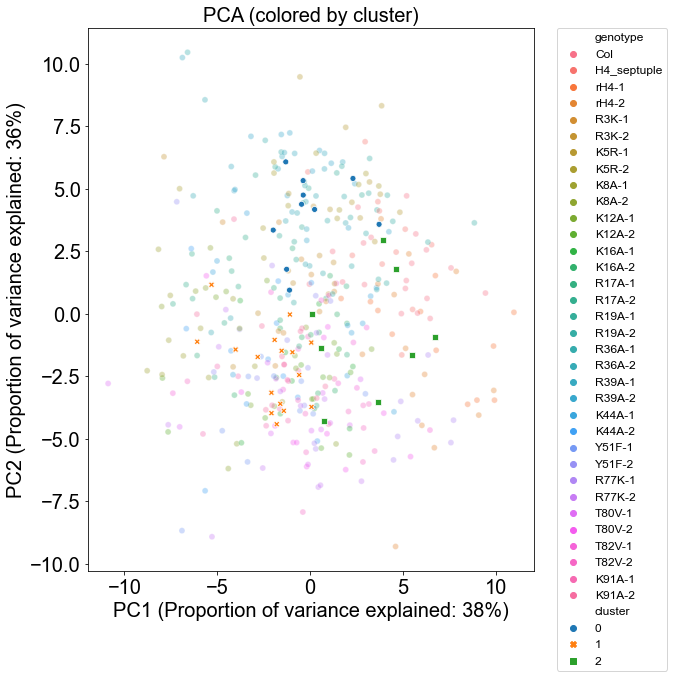

In [28]:
# Visualize 2D projection

# Color by k-means cluster
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by cluster)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue='cluster',  palette=sns.color_palette("tab10",n_clusters), style='cluster')
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.savefig(save_path+"/PCA/genotypescols_kmeansavg.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypescols_kmeansavg.pdf", bbox_inches='tight')

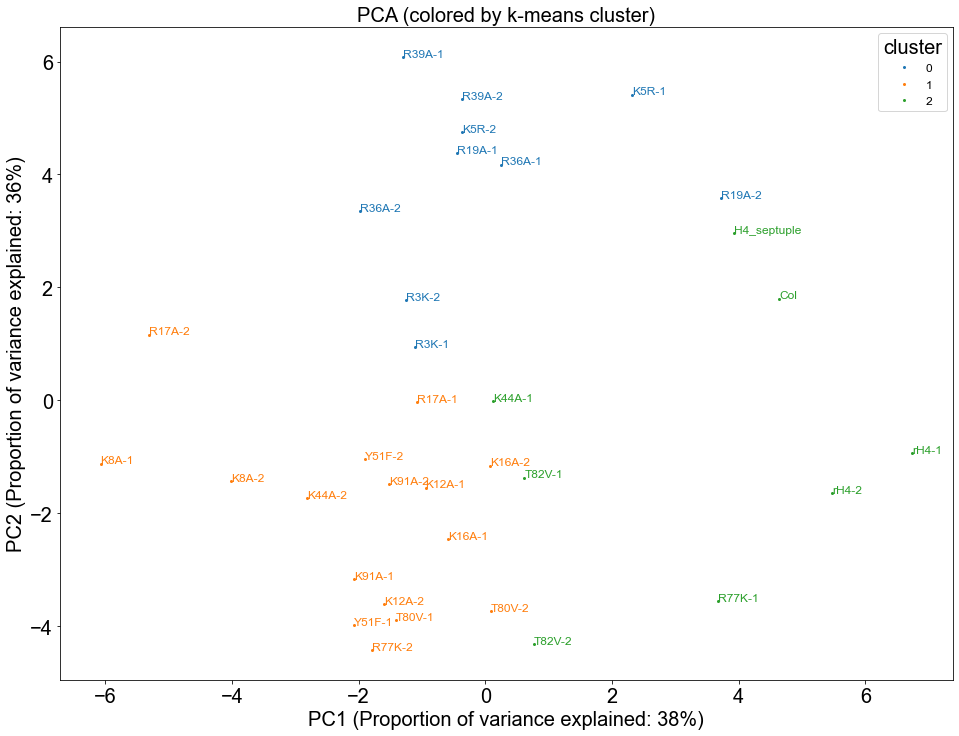

In [29]:
# Visualize 2D projection with averages labeled as text
palette = sns.set_palette("Set2")
x_col = 'PC1'
y_col = 'PC2'
hue_col = 'cluster'
palette = 'tab10'
size=2

# Color by cluster
fig = plt.figure(figsize = (16,12))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means cluster)', fontsize = 20)

colors = plt.cm.get_cmap(palette)(range(len(avg_finalDf[hue_col].unique())))
for (g,temp),c in zip(avg_finalDf.groupby('cluster'),colors):
    ax.plot(temp[x_col], temp[y_col], 'o', color=c, ms=size, label=g)
    for i,row in temp.iterrows():
        ax.annotate(row.name, xy=(row[x_col],row[y_col]), color=c, fontsize=12)

xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.legend(title=hue_col, fontsize=12)

plt.savefig(save_path+"/PCA/kmeansavg_labeled.png", bbox_inches='tight')

In [30]:
# Function to label points by genotype
def label_point(x, y, val):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point.name), fontsize=10)

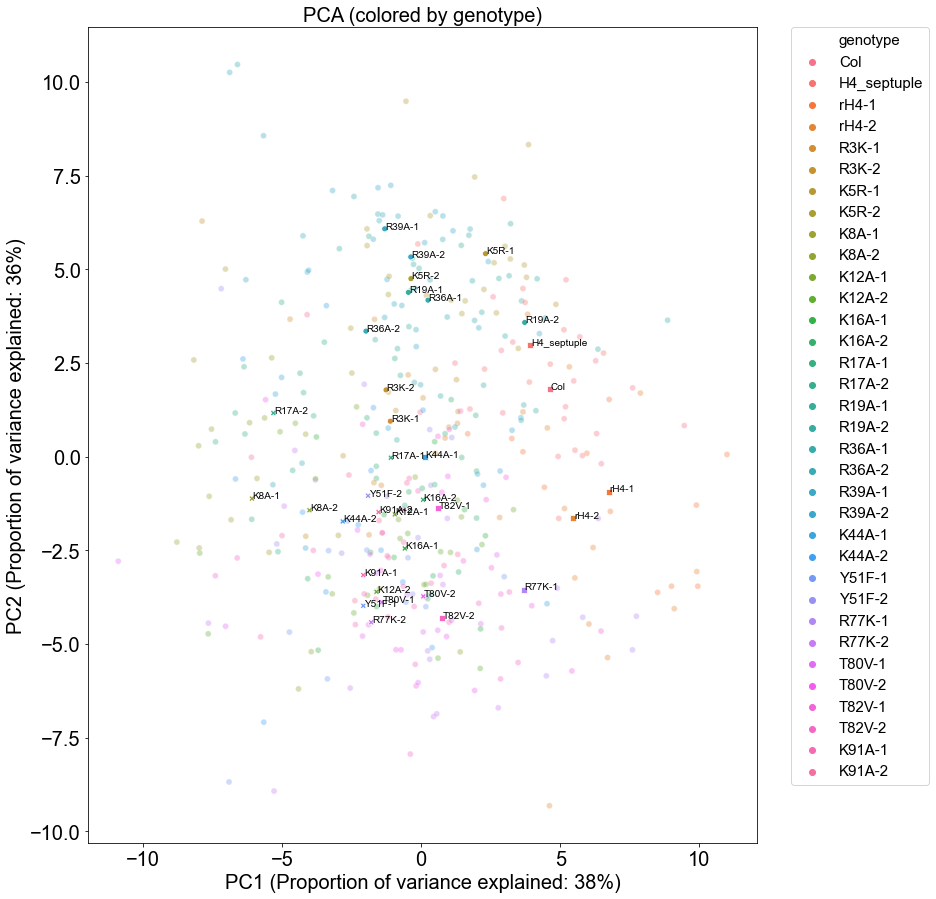

In [31]:
# Visualize 2D projection


# Color by genotype
fig = plt.figure(figsize = (12,15))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue=avg_finalDf.index, hue_order=order, style='cluster', legend=False)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=15)

label_point(avg_finalDf.PC1, avg_finalDf.PC2, plt.gca())

plt.savefig(save_path+"/PCA/genotypecols_avg_labeled.png", bbox_inches='tight')

## Save Output Files

In [32]:
avg_finalDf.to_csv(save_path+"/avg_traits.csv",index=True)

## Find traits with greatest correlation to PC1 and PC2

In [33]:
## Correlation matrix for every feature vs. PC1, PC2, and PC3
num_traits = df.shape[1]-2
corrmat = np.zeros([num_traits,3])
for i in range(num_traits):
    for j in range(3):
        xtest = df.iloc[:,i+2]
        ytest = finalDf.iloc[:,j]
        corr = xtest.corr(ytest)
        corrmat[i,j] = corr

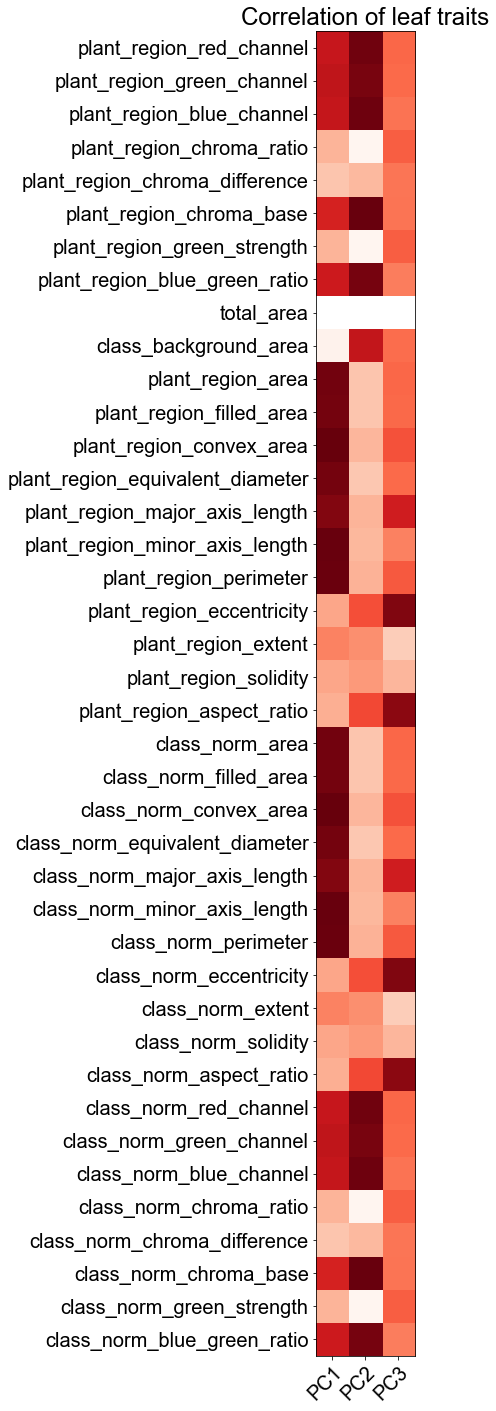

In [34]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.imshow(corrmat, cmap=cm.Reds)
#Label axes
ax.set_xticks(np.arange(corrmat.shape[1]))
ax.set_yticks(np.arange(corrmat.shape[0]))
ax.set_xticklabels(finalDf.columns[:3])
ax.set_yticklabels(df.columns[2:])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Correlation of leaf traits")
fig.tight_layout()
plt.savefig(save_path+"/Correlation_Heatmap_Vertical.png", bbox_inches='tight')
plt.savefig(save_path+"/Correlation_Heatmap_Vertical.pdf", bbox_inches='tight')

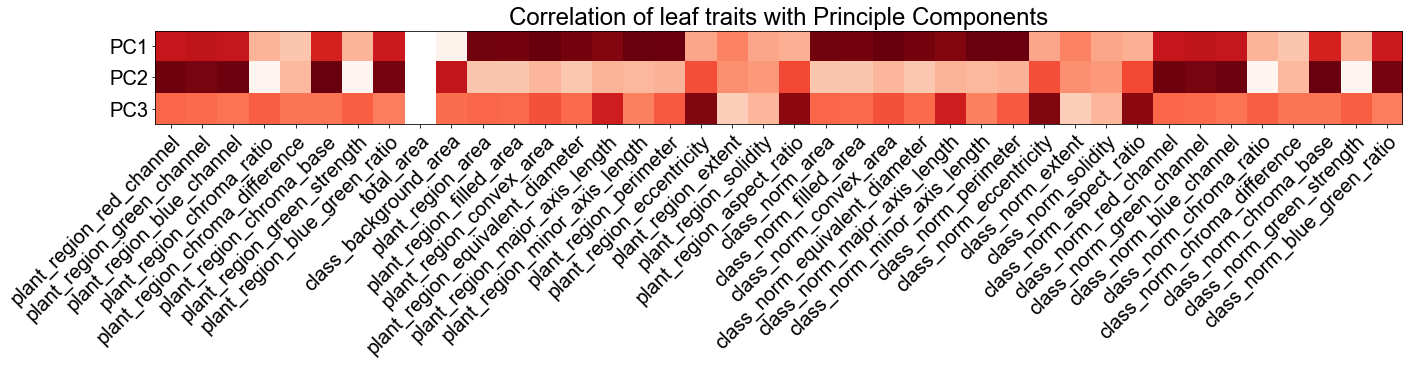

In [35]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.imshow(corrmat.transpose(), cmap=cm.Reds)
#Label axes
ax.set_xticks(np.arange(corrmat.shape[0]))
ax.set_yticks(np.arange(corrmat.shape[1]))
ax.set_yticklabels(finalDf.columns[:3])
ax.set_xticklabels(df.columns[2:])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation of leaf traits with Principle Components")
fig.tight_layout()
plt.savefig(save_path+"/Correlation_Heatmap_Horizontal.png", bbox_inches='tight')
plt.savefig(save_path+"/Correlation_Heatmap_Horizontal.pdf", bbox_inches='tight')

## Plot individual features by genotype

In [36]:
# Make individual dataframe for each feature and save as a csv file
def feature_csv(df, metadata, colnum):
    df_by_gen = pd.DataFrame()
    for genotype in metadata['genotype']:
        temp_df = pd.DataFrame()
        gen_data = df[df["genotype"] == genotype]
        coldata = gen_data.iloc[:,colnum+2]
        temp_df[genotype] = coldata.to_numpy()
        df_by_gen = pd.concat([df_by_gen, temp_df], axis=1)
    name = list(df.columns)[colnum+2]
    df_by_gen.to_csv(save_path+"/feature_csv/"+name+".csv",index=False)

In [37]:
feature_num = df.shape[1]-2
for i in range(feature_num):
    feature_csv(df, metadata, i)

In [38]:
# Calculate average and standard deviation for features and combine with average for each genotype
# Calculate averages 
avg_df = df.groupby('genotype').mean()
# Calculate standard deviations
avg_df = df.groupby('genotype').std()

In [39]:
avg_df.head()

,plant_region_red_channel,plant_region_green_channel,plant_region_blue_channel,plant_region_chroma_ratio,plant_region_chroma_difference,plant_region_chroma_base,plant_region_green_strength,plant_region_blue_green_ratio,total_area,class_background_area,...,class_norm_solidity,class_norm_aspect_ratio,class_norm_red_channel,class_norm_green_channel,class_norm_blue_channel,class_norm_chroma_ratio,class_norm_chroma_difference,class_norm_chroma_base,class_norm_green_strength,class_norm_blue_green_ratio
genotype,,,,,,,,,,,,,,,,,,,,,
Col,7.563721,8.276075,7.062427,0.036943,2.679555,0.030303,0.005823,0.021548,0.0,12891.576101,...,0.033428,0.107724,7.563721,8.276075,7.062427,0.036943,2.679555,0.030303,0.005823,0.021548
H4_septuple,9.844299,11.022037,8.481677,0.032694,2.394964,0.026808,0.005152,0.020052,0.0,11878.183052,...,0.028806,0.196274,9.844299,11.022037,8.481677,0.032694,2.394964,0.026808,0.005152,0.020052
K12A-1,7.793640,8.981545,5.976801,0.043363,2.990544,0.030078,0.006339,0.019361,0.0,12145.157684,...,0.028925,0.153442,7.793640,8.981545,5.976801,0.043363,2.990544,0.030078,0.006339,0.019361
K12A-2,10.414001,12.815012,7.350121,0.036980,4.238080,0.024323,0.005275,0.022181,0.0,14836.760139,...,0.039314,0.241292,10.414001,12.815012,7.350121,0.036980,4.238080,0.024323,0.005275,0.022181
K16A-1,8.318607,9.566962,7.148374,0.043366,2.117755,0.029640,0.006296,0.024013,0.0,10235.118362,...,0.037164,0.110101,8.318607,9.566962,7.148374,0.043366,2.117755,0.029640,0.006296,0.024013


In [40]:
def plot_feature(avg_df, feature_name):
    fig = plt.figure(figsize = (25, 5))
 
    # Create the bar plot
    plt.bar(avg_df.index, avg_df[feature_name], color ='maroon', width = 0.4)
    plt.xticks(rotation = 45)
    plt.ylabel(feature_name)
    
    # Save figure
    plt.savefig(save_path+"/Feature Plots/"+feature_name+".png", bbox_inches='tight')
    plt.savefig(save_path+"/Feature Plots/"+feature_name+".pdf", bbox_inches='tight')

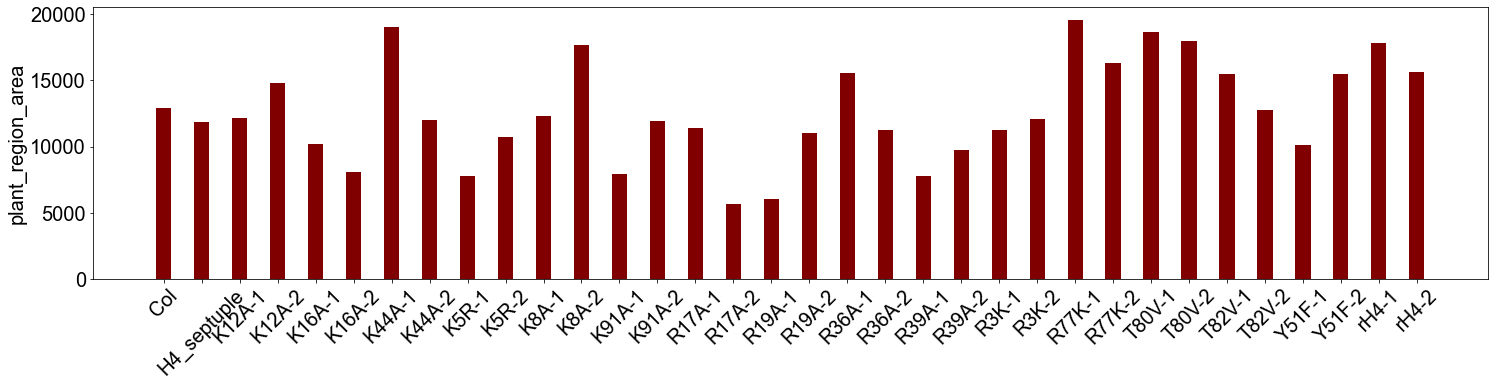

In [41]:
plot_feature(avg_df, "plant_region_area")

## Remove Features Related to Plant Color and Rerun Analyses

In [42]:
#Set path to save plot
save_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021/no_color_traits"

In [43]:
# Remove all features associated with colors
reduced_df = df.copy()
for i in range(feature_num):
    name = list(df.columns)[i+2]
    if "red" in name:
        reduced_df.drop([name],axis=1,inplace=True)
    elif "blue" in name:
        reduced_df.drop([name],axis=1,inplace=True)
    elif "green" in name:
        reduced_df.drop([name],axis=1,inplace=True)
    elif "chroma" in name:
        reduced_df.drop([name],axis=1,inplace=True)

In [44]:
reduced_df.head()

,file,genotype,total_area,class_background_area,plant_region_area,plant_region_filled_area,plant_region_convex_area,plant_region_equivalent_diameter,plant_region_major_axis_length,plant_region_minor_axis_length,...,class_norm_filled_area,class_norm_convex_area,class_norm_equivalent_diameter,class_norm_major_axis_length,class_norm_minor_axis_length,class_norm_perimeter,class_norm_eccentricity,class_norm_extent,class_norm_solidity,class_norm_aspect_ratio
0,4-6 6,K5R-1,321064,283465,37599,37699,52819,218.797929,347.271057,196.709862,...,37699,52819,218.797929,347.271057,196.709862,1758.155554,0.824100,0.494776,0.711846,1.765397
1,33-10 11,K44A-1,321064,235523,85541,86884,149682,330.021490,494.201007,399.818984,...,86884,149682,330.021490,494.201007,399.818984,3594.080661,0.587780,0.445526,0.571485,1.236062
2,33-11 3,K44A-2,321064,263711,57353,57471,108005,270.229731,431.920496,311.513451,...,57471,108005,270.229731,431.920496,311.513451,2849.527271,0.692697,0.348973,0.531022,1.386523
3,37-9 6,Y51F-2,321064,256837,64227,67115,97511,285.965656,384.009336,335.737412,...,67115,97511,285.965656,384.009336,335.737412,2572.093721,0.485395,0.432826,0.658664,1.143779
4,48-1 4,R77K-1,321064,252869,68195,68401,117979,294.666881,447.645941,370.273931,...,68401,117979,294.666881,447.645941,370.273931,3050.226802,0.561969,0.377759,0.578027,1.208959


## Individual plant data

### Perform PCA

In [45]:
df = reduced_df
#Make data frame
#Separate the features
x = df.iloc[:,2:].values
#Separate the labels
y = df.loc[:,['file']].values
y_cat = df.loc[:,['genotype']].values
# Standardize the features
x = StandardScaler().fit_transform(x)
n_features = x.shape[1]

In [46]:
# Run PCA to obtain all PCs
pca = PCA(n_components=n_features)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [47]:
# Run PCA to obtain all PCs
pca = PCA(n_components=n_features)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents[:,:3], columns=['PC1','PC2','PC3'])
finalDf = pd.concat([principalDf, df[['file']]], axis = 1)
finalDf = pd.concat([finalDf, df[['genotype']]], axis = 1)
finalDf.head()

,PC1,PC2,PC3,file,genotype
0,4.727160,-0.180784,5.130595,4-6 6,K5R-1
1,-5.996684,-0.087278,1.551010,33-10 11,K44A-1
2,-1.022998,2.076442,-0.062906,33-11 3,K44A-2
3,-1.501575,-2.408664,1.132242,37-9 6,Y51F-2
4,-3.098674,0.080426,0.073241,48-1 4,R77K-1


In [48]:
# Print proportions of explained variance by each PC
ex_var = pca.explained_variance_ratio_

In [49]:
ex_var.cumsum().shape

(24,)

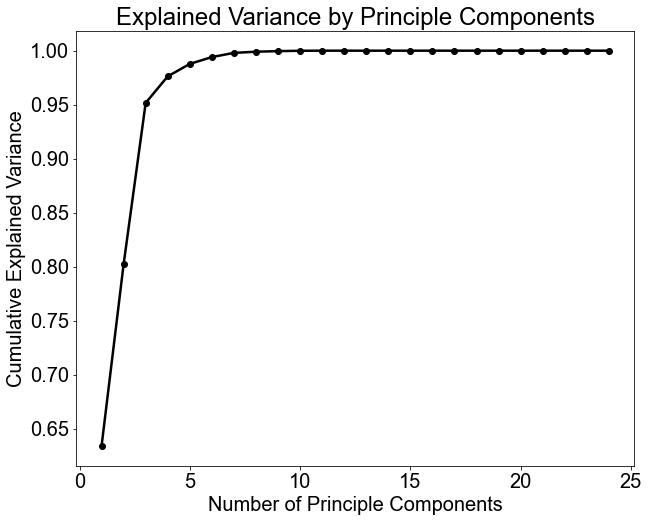

In [51]:
# Visualize scree plot
plt.figure(figsize=(10,8))
plt.plot(range(1,25),ex_var.cumsum(), marker='o', color='black')
plt.title('Explained Variance by Principle Components')
plt.xlabel("Number of Principle Components")
plt.ylabel('Cumulative Explained Variance')

plt.savefig(save_path+"/PCA/scree.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/scree.pdf", bbox_inches='tight')

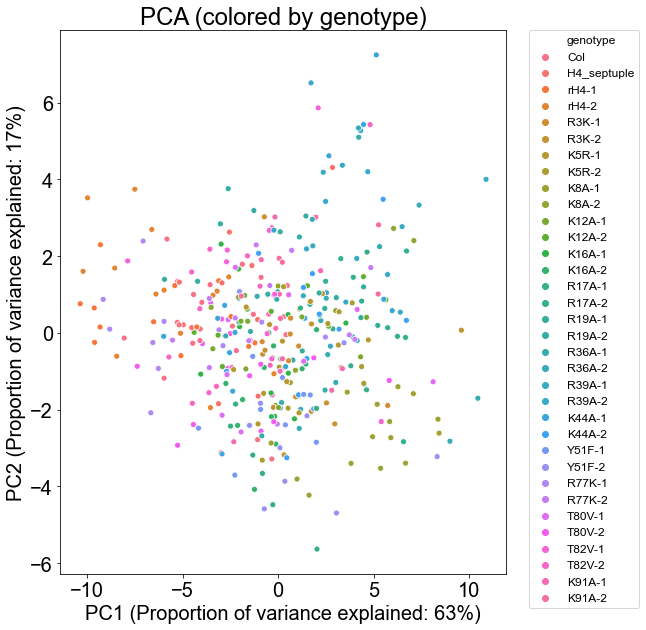

In [52]:
# Visualize 2D projection

# Set Plotting Parameters
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 2.5

# Color by genotype
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)')
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.savefig(save_path+"/PCA/genotypes.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypes.pdf", bbox_inches='tight')

## Perform k-means Clustering

In [53]:
# Run k-means
n_clusters=3
kmeans_labels = KMeans(n_clusters=n_clusters).fit_predict(x)

In [54]:
finalDf['cluster'] = kmeans_labels
finalDf.head()

,PC1,PC2,PC3,file,genotype,cluster
0,4.727160,-0.180784,5.130595,4-6 6,K5R-1,1
1,-5.996684,-0.087278,1.551010,33-10 11,K44A-1,0
2,-1.022998,2.076442,-0.062906,33-11 3,K44A-2,2
3,-1.501575,-2.408664,1.132242,37-9 6,Y51F-2,2
4,-3.098674,0.080426,0.073241,48-1 4,R77K-1,0


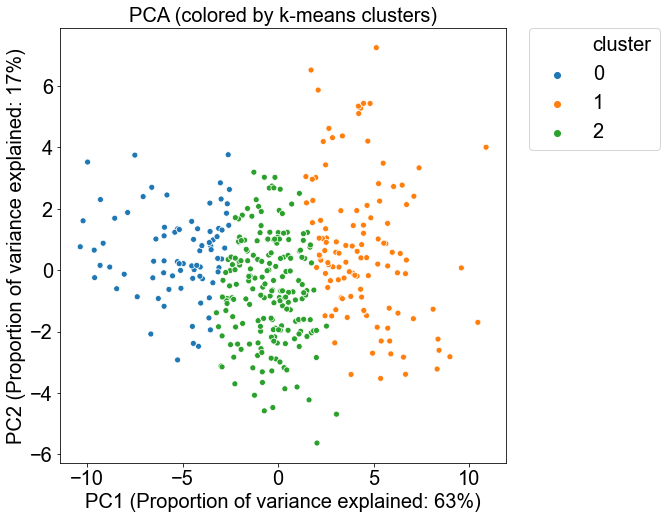

In [55]:
# Visualize 2D projection with k-means labels

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means clusters)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='cluster', palette=sns.color_palette("tab10",n_clusters))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(save_path+"/PCA/kmeans.png", bbox_inches='tight')

## Average data by genotype

In [56]:
# Average data by genotype
avg_finalDf = finalDf.groupby('genotype').mean()

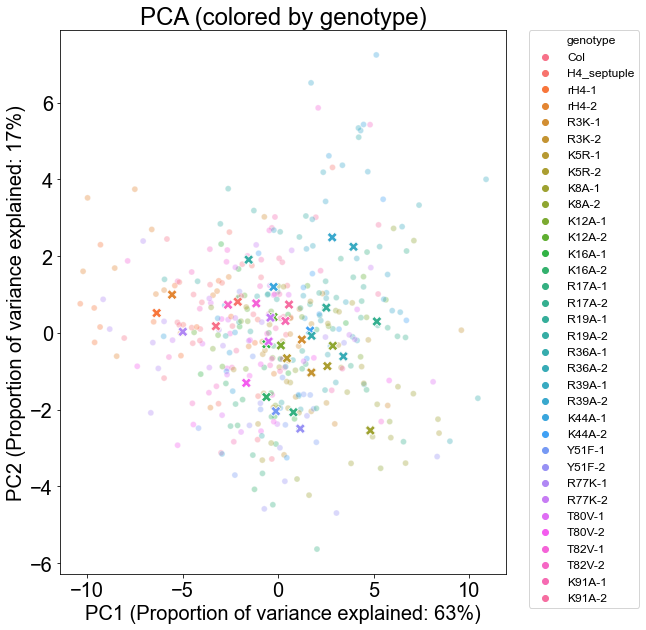

In [57]:
# Visualize averages on top of individual replicates
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)')
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue=avg_finalDf.index, hue_order=order, 
                palette=sns.color_palette("husl", 34), marker='X', s=100, legend=False)
ax.set(xlabel=xlab, ylabel = ylab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.savefig(save_path+"/PCA/genotypecols_genotypeavg.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypecols_genotypeavg.pdf", bbox_inches='tight')

## k-means Clustering

In [58]:
avg_finalDf['cluster'] = 'NA'

In [59]:
# assign genotypes to cluster by mode from biological replicates
for genotype in avg_finalDf.index:
    group = finalDf.loc[finalDf['genotype'] == genotype]
    cluster_num = group['cluster'].mode()
    final_cluster = cluster_num.iat[-1]
    avg_finalDf.at[genotype,"cluster"] = final_cluster

In [60]:
avg_finalDf.head()

,PC1,PC2,PC3,cluster
genotype,,,,
Col,-3.259418,0.176228,0.332845,0
H4_septuple,-2.114683,0.813067,-1.392228,2
K12A-1,0.144033,-0.325795,-0.033265,2
K12A-2,-0.243234,0.413107,1.033055,2
K16A-1,-0.608476,-0.291771,-0.262241,2


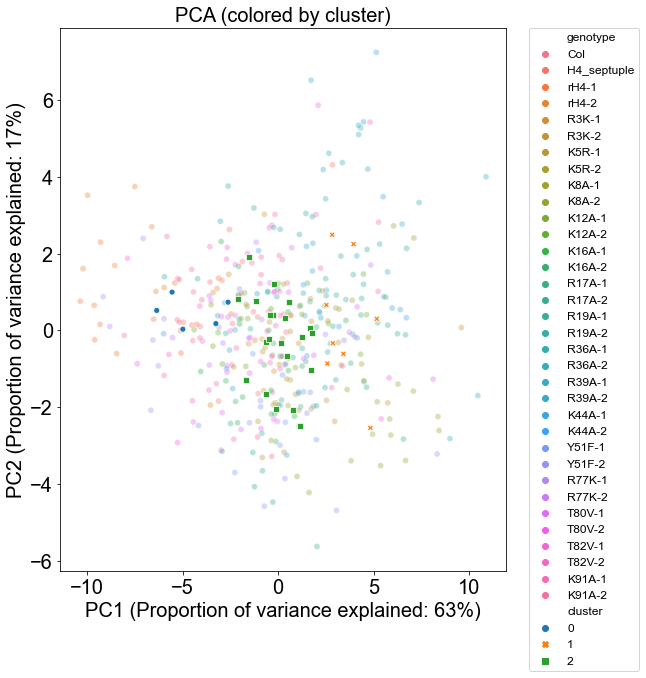

In [61]:
# Visualize 2D projection

# Color by k-means cluster
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by cluster)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue='cluster',  palette=sns.color_palette("tab10",n_clusters), style='cluster')
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.savefig(save_path+"/PCA/genotypescols_kmeansavg.png", bbox_inches='tight', dpi=300)
plt.savefig(save_path+"/PCA/genotypescols_kmeansavg.pdf", bbox_inches='tight')

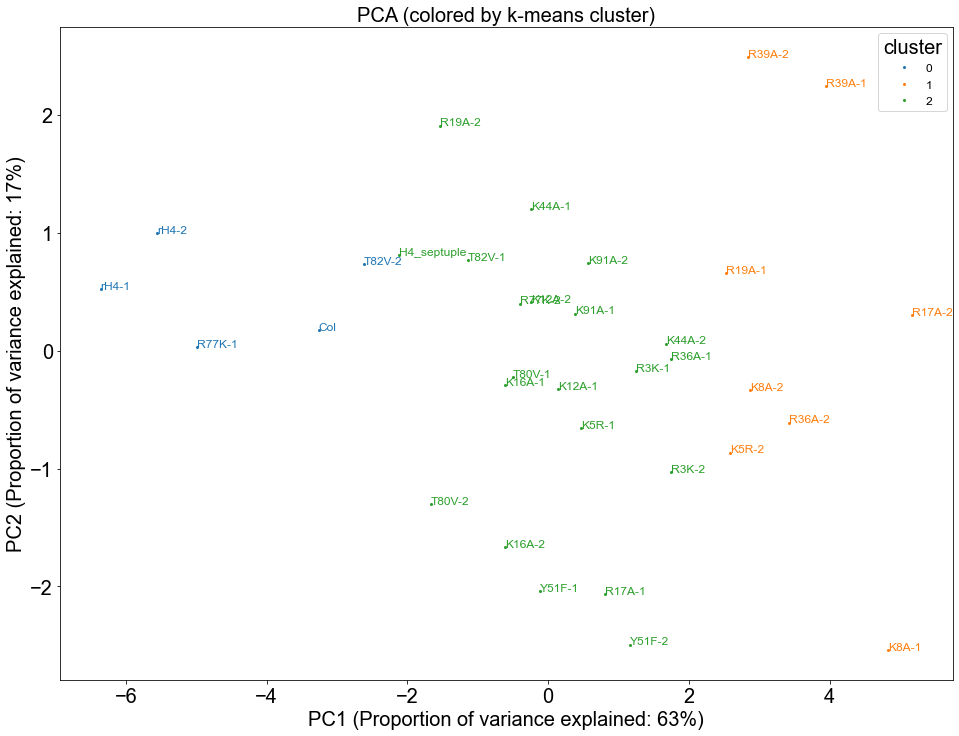

In [62]:
# Visualize 2D projection with averages labeled as text
palette = sns.set_palette("Set2")
x_col = 'PC1'
y_col = 'PC2'
hue_col = 'cluster'
palette = 'tab10'
size=2

# Color by cluster
fig = plt.figure(figsize = (16,12))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means cluster)', fontsize = 20)

colors = plt.cm.get_cmap(palette)(range(len(avg_finalDf[hue_col].unique())))
for (g,temp),c in zip(avg_finalDf.groupby('cluster'),colors):
    ax.plot(temp[x_col], temp[y_col], 'o', color=c, ms=size, label=g)
    for i,row in temp.iterrows():
        ax.annotate(row.name, xy=(row[x_col],row[y_col]), color=c, fontsize=12)

xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.legend(title=hue_col, fontsize=12)

plt.savefig(save_path+"/PCA/kmeansavg_labeled.png", bbox_inches='tight')

In [63]:
# Function to label points by genotype
def label_point(x, y, val):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point.name), fontsize=10)

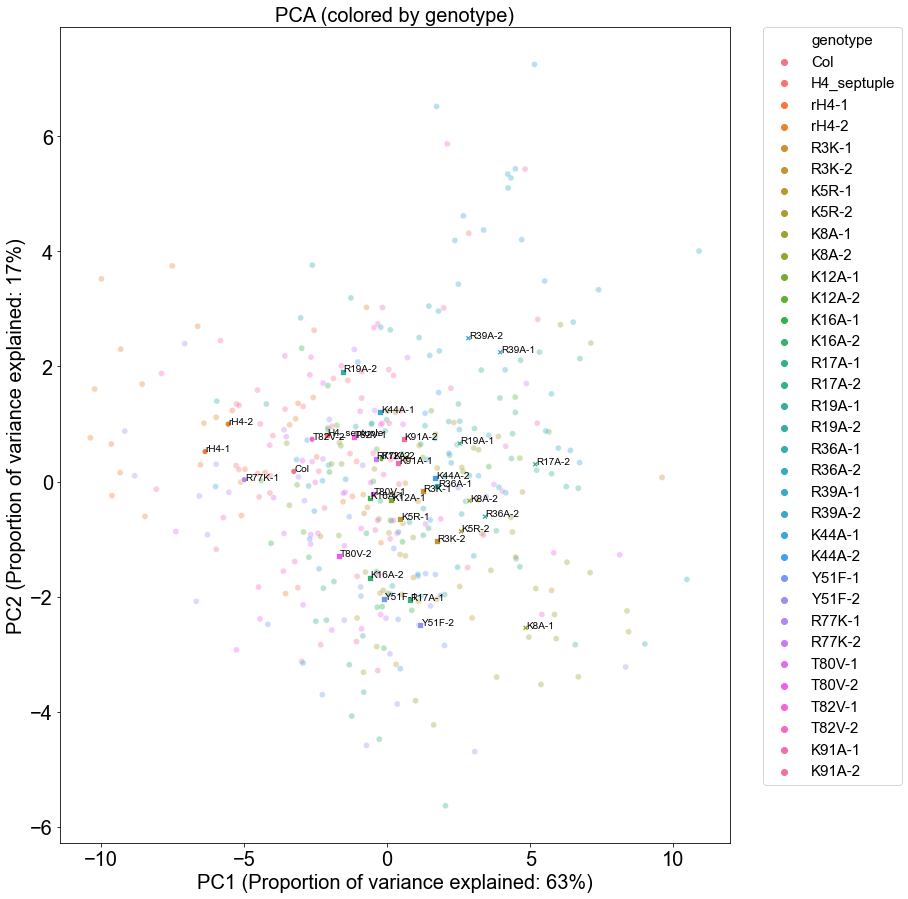

In [64]:
# Visualize 2D projection


# Color by genotype
fig = plt.figure(figsize = (12,15))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_finalDf, hue=avg_finalDf.index, hue_order=order, style='cluster', legend=False)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=15)

label_point(avg_finalDf.PC1, avg_finalDf.PC2, plt.gca())

plt.savefig(save_path+"/PCA/genotypecols_avg_labeled.png", bbox_inches='tight')

## Save Output Files

In [65]:
avg_finalDf.to_csv(save_path+"/avg_traits.csv",index=True)

## Find traits with greatest correlation to PC1 and PC2

In [66]:
## Correlation matrix for every feature vs. PC1, PC2, and PC3
num_traits = df.shape[1]-2
corrmat = np.zeros([num_traits,3])
for i in range(num_traits):
    for j in range(3):
        xtest = df.iloc[:,i+2]
        ytest = finalDf.iloc[:,j]
        corr = xtest.corr(ytest)
        corrmat[i,j] = corr

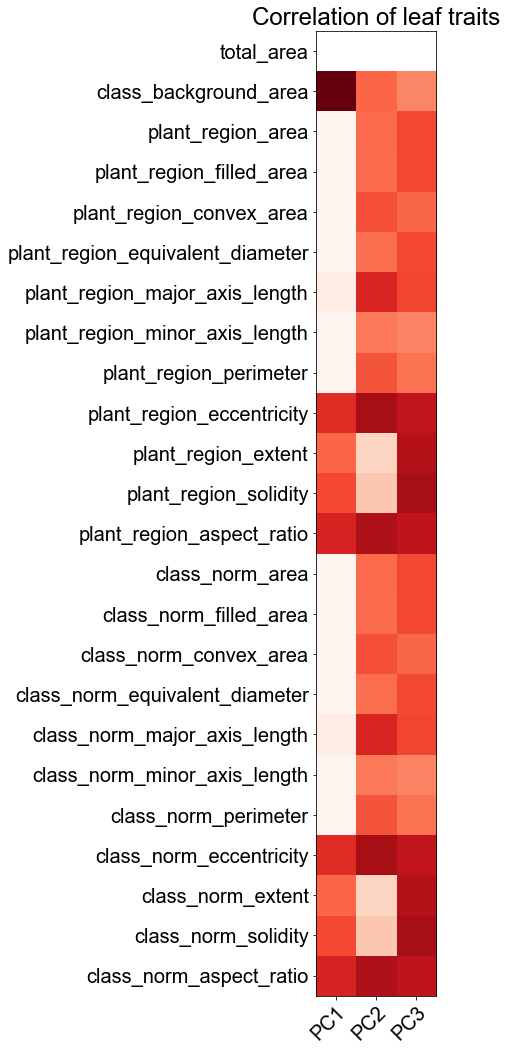

In [69]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.imshow(corrmat, cmap=cm.Reds)
#Label axes
ax.set_xticks(np.arange(corrmat.shape[1]))
ax.set_yticks(np.arange(corrmat.shape[0]))
ax.set_xticklabels(finalDf.columns[:3])
ax.set_yticklabels(df.columns[2:])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Correlation of leaf traits")
fig.tight_layout()
plt.savefig(save_path+"/Correlation_Heatmap_Vertical.png", bbox_inches='tight')
plt.savefig(save_path+"/Correlation_Heatmap_Vertical.pdf", bbox_inches='tight')

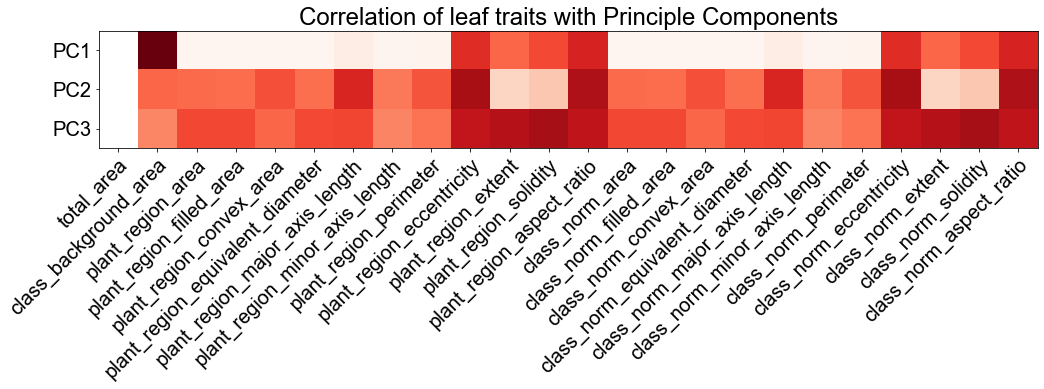

In [70]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.imshow(corrmat.transpose(), cmap=cm.Reds)
#Label axes
ax.set_xticks(np.arange(corrmat.shape[0]))
ax.set_yticks(np.arange(corrmat.shape[1]))
ax.set_yticklabels(finalDf.columns[:3])
ax.set_xticklabels(df.columns[2:])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation of leaf traits with Principle Components")
fig.tight_layout()
plt.savefig(save_path+"/Correlation_Heatmap_Horizontal.png", bbox_inches='tight')
plt.savefig(save_path+"/Correlation_Heatmap_Horizontal.pdf", bbox_inches='tight')